In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_11732/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79:

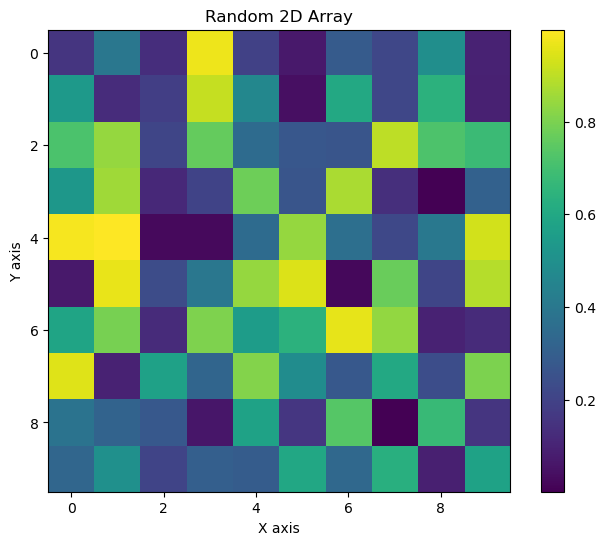

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == False
    if BPTT_on == True:
        assert tdBN_on == False
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            if (single_step == False):
                net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
            else:
                net = MY_SNN_FC_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
        else:
            if (single_step == False):
                net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
            else:
                net = MY_SNN_CONV_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()

            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################



            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### 모듈 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## 모듈 세이브 ###########################################################################################
            # np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            # np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            # np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            # with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "1",
                single_step = True, # True # False
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on True 

지금 ottt만해라. 아니면 data_loader와서 바꿔라
Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_ottt_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): 

0-390/391 iter:51.25%, lr=['0.1'], iter_loss:0.21705977618694305, val:52.17%, val_best:52.17%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.9883623123169 seconds

EPOCH 1



1-390/391 iter:57.50%, lr=['0.09999725846827562'], iter_loss:0.17852525413036346, val:63.16%, val_best:63.16%: 100%|██████████| 391/391 [04:26<00:00,  1.47it/s]

epoch_time: 267.07909321784973 seconds

EPOCH 2



2-390/391 iter:58.75%, lr=['0.09998903417374229'], iter_loss:0.1525607705116272, val:69.94%, val_best:69.94%: 100%|██████████| 391/391 [03:53<00:00,  1.67it/s]

epoch_time: 233.9792182445526 seconds

EPOCH 3



3-390/391 iter:62.50%, lr=['0.0999753280182866'], iter_loss:0.12945395708084106, val:73.54%, val_best:73.54%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s]

epoch_time: 253.9093689918518 seconds

EPOCH 4



4-390/391 iter:71.25%, lr=['0.09995614150494293'], iter_loss:0.12229343503713608, val:74.56%, val_best:74.56%: 100%|██████████| 391/391 [03:47<00:00,  1.72it/s]

epoch_time: 227.20824122428894 seconds

EPOCH 5



5-390/391 iter:78.75%, lr=['0.0999314767377287'], iter_loss:0.14742040634155273, val:77.27%, val_best:77.27%: 100%|██████████| 391/391 [04:50<00:00,  1.35it/s]

epoch_time: 290.52821612358093 seconds

EPOCH 6



6-390/391 iter:76.25%, lr=['0.09990133642141359'], iter_loss:0.1338176727294922, val:79.08%, val_best:79.08%: 100%|██████████| 391/391 [04:03<00:00,  1.61it/s]

epoch_time: 243.76581287384033 seconds

EPOCH 7



7-390/391 iter:83.75%, lr=['0.0998657238612229'], iter_loss:0.10018685460090637, val:79.46%, val_best:79.46%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]

epoch_time: 242.20442938804626 seconds

EPOCH 8



8-390/391 iter:78.75%, lr=['0.09982464296247523'], iter_loss:0.07102905213832855, val:82.05%, val_best:82.05%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]

epoch_time: 260.50925731658936 seconds

EPOCH 9



9-390/391 iter:80.00%, lr=['0.099778098230154'], iter_loss:0.08197568356990814, val:81.82%, val_best:82.05%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]

epoch_time: 241.63102793693542 seconds

EPOCH 10



10-390/391 iter:81.25%, lr=['0.09972609476841367'], iter_loss:0.08321468532085419, val:83.35%, val_best:83.35%: 100%|██████████| 391/391 [04:29<00:00,  1.45it/s]

epoch_time: 270.18757152557373 seconds

EPOCH 11



11-390/391 iter:88.75%, lr=['0.09966863828001983'], iter_loss:0.07450998574495316, val:83.44%, val_best:83.44%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s]

epoch_time: 247.7114245891571 seconds

EPOCH 12



12-390/391 iter:86.25%, lr=['0.09960573506572391'], iter_loss:0.07788858562707901, val:85.10%, val_best:85.10%: 100%|██████████| 391/391 [04:17<00:00,  1.52it/s]

epoch_time: 257.7372097969055 seconds

EPOCH 13



13-390/391 iter:78.75%, lr=['0.09953739202357219'], iter_loss:0.10943678021430969, val:85.76%, val_best:85.76%: 100%|██████████| 391/391 [04:02<00:00,  1.61it/s]

epoch_time: 242.4857575893402 seconds

EPOCH 14



14-390/391 iter:83.75%, lr=['0.09946361664814943'], iter_loss:0.08885759115219116, val:86.23%, val_best:86.23%: 100%|██████████| 391/391 [04:06<00:00,  1.58it/s]

epoch_time: 247.1155481338501 seconds

EPOCH 15



15-390/391 iter:85.00%, lr=['0.0993844170297569'], iter_loss:0.07794337719678879, val:86.13%, val_best:86.23%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]

epoch_time: 249.98406600952148 seconds

EPOCH 16



16-390/391 iter:86.25%, lr=['0.09929980185352526'], iter_loss:0.07573162764310837, val:86.29%, val_best:86.29%: 100%|██████████| 391/391 [04:25<00:00,  1.47it/s]

epoch_time: 265.95950412750244 seconds

EPOCH 17



17-390/391 iter:92.50%, lr=['0.0992097803984621'], iter_loss:0.07133705914020538, val:87.37%, val_best:87.37%: 100%|██████████| 391/391 [03:50<00:00,  1.70it/s]

epoch_time: 230.57944107055664 seconds

EPOCH 18



18-390/391 iter:85.00%, lr=['0.09911436253643445'], iter_loss:0.07834537327289581, val:87.45%, val_best:87.45%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s]

epoch_time: 262.621027469635 seconds

EPOCH 19



19-390/391 iter:90.00%, lr=['0.09901355873108611'], iter_loss:0.07635469734668732, val:87.73%, val_best:87.73%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s]

epoch_time: 251.93522024154663 seconds

EPOCH 20



20-390/391 iter:90.00%, lr=['0.09890738003669029'], iter_loss:0.049315743148326874, val:88.08%, val_best:88.08%: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s]

epoch_time: 256.8615996837616 seconds

EPOCH 21



21-390/391 iter:80.00%, lr=['0.09879583809693737'], iter_loss:0.07591544091701508, val:87.68%, val_best:88.08%: 100%|██████████| 391/391 [04:34<00:00,  1.43it/s]

epoch_time: 274.1798255443573 seconds

EPOCH 22



22-390/391 iter:90.00%, lr=['0.09867894514365802'], iter_loss:0.06266706436872482, val:87.77%, val_best:88.08%: 100%|██████████| 391/391 [03:48<00:00,  1.71it/s]

epoch_time: 228.91429567337036 seconds

EPOCH 23



23-390/391 iter:82.50%, lr=['0.09855671399548181'], iter_loss:0.10217051953077316, val:88.97%, val_best:88.97%: 100%|██████████| 391/391 [04:16<00:00,  1.53it/s]

epoch_time: 256.4494643211365 seconds

EPOCH 24



24-390/391 iter:93.75%, lr=['0.09842915805643157'], iter_loss:0.09628628939390182, val:89.14%, val_best:89.14%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s]

epoch_time: 234.5256109237671 seconds

EPOCH 25



25-390/391 iter:91.25%, lr=['0.09829629131445343'], iter_loss:0.0558081790804863, val:89.18%, val_best:89.18%: 100%|██████████| 391/391 [04:14<00:00,  1.53it/s] 

epoch_time: 255.11976671218872 seconds

EPOCH 26



26-390/391 iter:90.00%, lr=['0.09815812833988292'], iter_loss:0.1086571216583252, val:88.88%, val_best:89.18%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s] 

epoch_time: 259.49468421936035 seconds

EPOCH 27



27-390/391 iter:95.00%, lr=['0.09801468428384717'], iter_loss:0.06761616468429565, val:89.64%, val_best:89.64%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]

epoch_time: 244.11866927146912 seconds

EPOCH 28



28-390/391 iter:92.50%, lr=['0.09786597487660338'], iter_loss:0.09329834580421448, val:88.64%, val_best:89.64%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s]

epoch_time: 254.52556228637695 seconds

EPOCH 29



29-390/391 iter:95.00%, lr=['0.09771201642581387'], iter_loss:0.07346399873495102, val:89.41%, val_best:89.64%: 100%|██████████| 391/391 [04:21<00:00,  1.50it/s]

epoch_time: 261.2086477279663 seconds

EPOCH 30



30-390/391 iter:92.50%, lr=['0.09755282581475772'], iter_loss:0.09368294477462769, val:89.64%, val_best:89.64%: 100%|██████████| 391/391 [03:58<00:00,  1.64it/s]

epoch_time: 238.86272954940796 seconds

EPOCH 31



31-390/391 iter:92.50%, lr=['0.09738842050047931'], iter_loss:0.06788705289363861, val:89.68%, val_best:89.68%: 100%|██████████| 391/391 [04:34<00:00,  1.42it/s]

epoch_time: 275.04712104797363 seconds

EPOCH 32



32-390/391 iter:96.25%, lr=['0.09721881851187408'], iter_loss:0.09701895713806152, val:89.74%, val_best:89.74%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s]

epoch_time: 252.533545255661 seconds

EPOCH 33



33-390/391 iter:97.50%, lr=['0.0970440384477113'], iter_loss:0.05930592864751816, val:90.34%, val_best:90.34%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]

epoch_time: 260.3709363937378 seconds

EPOCH 34



34-390/391 iter:95.00%, lr=['0.0968640994745946'], iter_loss:0.08544033765792847, val:90.37%, val_best:90.37%: 100%|██████████| 391/391 [04:28<00:00,  1.45it/s]

epoch_time: 269.01365876197815 seconds

EPOCH 35



35-390/391 iter:93.75%, lr=['0.0966790213248601'], iter_loss:0.06886734068393707, val:90.15%, val_best:90.37%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s]

epoch_time: 262.5387885570526 seconds

EPOCH 36



36-390/391 iter:93.75%, lr=['0.09648882429441259'], iter_loss:0.059223778545856476, val:90.20%, val_best:90.37%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s]

epoch_time: 249.63253474235535 seconds

EPOCH 37



37-390/391 iter:96.25%, lr=['0.09629352924049978'], iter_loss:0.0643400251865387, val:90.37%, val_best:90.37%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s] 

epoch_time: 234.42958855628967 seconds

EPOCH 38



38-390/391 iter:95.00%, lr=['0.09609315757942506'], iter_loss:0.06971442699432373, val:90.64%, val_best:90.64%: 100%|██████████| 391/391 [04:29<00:00,  1.45it/s] 

epoch_time: 269.47134804725647 seconds

EPOCH 39



39-390/391 iter:96.25%, lr=['0.09588773128419908'], iter_loss:0.09118866175413132, val:90.75%, val_best:90.75%: 100%|██████████| 391/391 [04:23<00:00,  1.49it/s]

epoch_time: 263.34800243377686 seconds

EPOCH 40



40-390/391 iter:92.50%, lr=['0.09567727288213007'], iter_loss:0.11086182296276093, val:90.84%, val_best:90.84%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s] 

epoch_time: 231.38523745536804 seconds

EPOCH 41



41-390/391 iter:96.25%, lr=['0.09546180545235346'], iter_loss:0.058422498404979706, val:90.84%, val_best:90.84%: 100%|██████████| 391/391 [03:43<00:00,  1.75it/s]

epoch_time: 224.253356218338 seconds

EPOCH 42



42-390/391 iter:93.75%, lr=['0.09524135262330101'], iter_loss:0.06550654768943787, val:90.64%, val_best:90.84%: 100%|██████████| 391/391 [03:42<00:00,  1.75it/s]

epoch_time: 223.10765433311462 seconds

EPOCH 43



43-390/391 iter:92.50%, lr=['0.09501593857010972'], iter_loss:0.0415198914706707, val:90.37%, val_best:90.84%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s] 

epoch_time: 264.49666476249695 seconds

EPOCH 44



44-390/391 iter:96.25%, lr=['0.09478558801197068'], iter_loss:0.049234241247177124, val:90.99%, val_best:90.99%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s]

epoch_time: 234.98351311683655 seconds

EPOCH 45



45-390/391 iter:97.50%, lr=['0.09455032620941842'], iter_loss:0.08416523784399033, val:90.91%, val_best:90.99%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.44139194488525 seconds

EPOCH 46



46-390/391 iter:95.00%, lr=['0.09431017896156076'], iter_loss:0.059023838490247726, val:90.75%, val_best:90.99%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]

epoch_time: 243.77532315254211 seconds

EPOCH 47



47-390/391 iter:97.50%, lr=['0.09406517260324962'], iter_loss:0.06465847790241241, val:91.22%, val_best:91.22%: 100%|██████████| 391/391 [04:41<00:00,  1.39it/s] 

epoch_time: 281.1939718723297 seconds

EPOCH 48



48-390/391 iter:90.00%, lr=['0.09381533400219319'], iter_loss:0.06018352508544922, val:90.95%, val_best:91.22%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]

epoch_time: 246.11773800849915 seconds

EPOCH 49



49-390/391 iter:97.50%, lr=['0.09356069055600949'], iter_loss:0.12091374397277832, val:91.20%, val_best:91.22%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]

epoch_time: 245.85666465759277 seconds

EPOCH 50



50-390/391 iter:97.50%, lr=['0.09330127018922195'], iter_loss:0.057056501507759094, val:91.57%, val_best:91.57%: 100%|██████████| 391/391 [04:31<00:00,  1.44it/s]

epoch_time: 271.23767709732056 seconds

EPOCH 51



51-390/391 iter:97.50%, lr=['0.0930371013501972'], iter_loss:0.10555553436279297, val:91.23%, val_best:91.57%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s] 

epoch_time: 231.9796495437622 seconds

EPOCH 52



52-390/391 iter:93.75%, lr=['0.09276821300802535'], iter_loss:0.05314270779490471, val:91.20%, val_best:91.57%: 100%|██████████| 391/391 [04:21<00:00,  1.50it/s] 

epoch_time: 261.4890902042389 seconds

EPOCH 53



53-390/391 iter:96.25%, lr=['0.09249463464934321'], iter_loss:0.06543262302875519, val:91.03%, val_best:91.57%: 100%|██████████| 391/391 [04:21<00:00,  1.49it/s] 

epoch_time: 261.90047001838684 seconds

EPOCH 54



54-390/391 iter:97.50%, lr=['0.09221639627510077'], iter_loss:0.07910818606615067, val:91.20%, val_best:91.57%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s]

epoch_time: 253.7666437625885 seconds

EPOCH 55



55-390/391 iter:98.75%, lr=['0.09193352839727122'], iter_loss:0.09095393121242523, val:91.07%, val_best:91.57%: 100%|██████████| 391/391 [04:06<00:00,  1.59it/s] 

epoch_time: 246.4000186920166 seconds

EPOCH 56



56-390/391 iter:97.50%, lr=['0.09164606203550499'], iter_loss:0.0730559378862381, val:91.39%, val_best:91.57%: 100%|██████████| 391/391 [03:53<00:00,  1.68it/s]  

epoch_time: 233.40835976600647 seconds

EPOCH 57



57-390/391 iter:96.25%, lr=['0.0913540287137281'], iter_loss:0.05785128474235535, val:91.42%, val_best:91.57%: 100%|██████████| 391/391 [04:29<00:00,  1.45it/s] 

epoch_time: 269.6996343135834 seconds

EPOCH 58



58-390/391 iter:96.25%, lr=['0.09105746045668521'], iter_loss:0.06730234622955322, val:91.65%, val_best:91.65%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s] 

epoch_time: 251.95247411727905 seconds

EPOCH 59



59-390/391 iter:96.25%, lr=['0.09075638978642771'], iter_loss:0.04807707294821739, val:91.91%, val_best:91.91%: 100%|██████████| 391/391 [04:13<00:00,  1.54it/s] 

epoch_time: 253.43716955184937 seconds

EPOCH 60



60-390/391 iter:100.00%, lr=['0.09045084971874738'], iter_loss:0.05886375531554222, val:91.72%, val_best:91.91%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s]

epoch_time: 258.7350344657898 seconds

EPOCH 61



61-390/391 iter:98.75%, lr=['0.09014087375955573'], iter_loss:0.09108319133520126, val:91.85%, val_best:91.91%: 100%|██████████| 391/391 [04:24<00:00,  1.48it/s] 

epoch_time: 264.90181064605713 seconds

EPOCH 62



62-390/391 iter:95.00%, lr=['0.08982649590120982'], iter_loss:0.12198524177074432, val:91.64%, val_best:91.91%: 100%|██████████| 391/391 [04:11<00:00,  1.56it/s] 

epoch_time: 251.31938791275024 seconds

EPOCH 63



63-390/391 iter:96.25%, lr=['0.08950775061878452'], iter_loss:0.08454864472150803, val:91.54%, val_best:91.91%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 

epoch_time: 262.81749200820923 seconds

EPOCH 64



64-390/391 iter:95.00%, lr=['0.089184672866292'], iter_loss:0.04261132702231407, val:91.60%, val_best:91.91%: 100%|██████████| 391/391 [04:39<00:00,  1.40it/s] 

epoch_time: 279.36597633361816 seconds

EPOCH 65



65-390/391 iter:95.00%, lr=['0.08885729807284856'], iter_loss:0.08812068402767181, val:91.33%, val_best:91.91%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 268.03539967536926 seconds

EPOCH 66



66-390/391 iter:97.50%, lr=['0.08852566213878947'], iter_loss:0.09615053236484528, val:91.68%, val_best:91.91%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.36304426193237 seconds

EPOCH 67



67-390/391 iter:95.00%, lr=['0.08818980143173213'], iter_loss:0.08919277787208557, val:91.99%, val_best:91.99%: 100%|██████████| 391/391 [04:07<00:00,  1.58it/s] 

epoch_time: 247.7252595424652 seconds

EPOCH 68



68-390/391 iter:96.25%, lr=['0.08784975278258783'], iter_loss:0.07705313712358475, val:91.68%, val_best:91.99%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.84354853630066 seconds

EPOCH 69



69-390/391 iter:95.00%, lr=['0.08750555348152299'], iter_loss:0.04538743942975998, val:91.91%, val_best:91.99%: 100%|██████████| 391/391 [04:32<00:00,  1.44it/s] 

epoch_time: 272.2733681201935 seconds

EPOCH 70



70-390/391 iter:97.50%, lr=['0.08715724127386973'], iter_loss:0.0759676843881607, val:91.89%, val_best:91.99%: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s]  

epoch_time: 256.9481875896454 seconds

EPOCH 71



71-390/391 iter:96.25%, lr=['0.08680485435598673'], iter_loss:0.09117119014263153, val:91.69%, val_best:91.99%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s] 

epoch_time: 244.88856720924377 seconds

EPOCH 72



72-390/391 iter:100.00%, lr=['0.0864484313710706'], iter_loss:0.1028938814997673, val:91.50%, val_best:91.99%: 100%|██████████| 391/391 [03:54<00:00,  1.67it/s] 

epoch_time: 234.96884107589722 seconds

EPOCH 73



73-390/391 iter:97.50%, lr=['0.08608801140491813'], iter_loss:0.07516561448574066, val:91.95%, val_best:91.99%: 100%|██████████| 391/391 [04:16<00:00,  1.52it/s] 

epoch_time: 256.9330401420593 seconds

EPOCH 74



74-390/391 iter:100.00%, lr=['0.0857236339816402'], iter_loss:0.09039150178432465, val:91.98%, val_best:91.99%: 100%|██████████| 391/391 [03:56<00:00,  1.66it/s]

epoch_time: 236.34019565582275 seconds

EPOCH 75



75-390/391 iter:96.25%, lr=['0.0853553390593274'], iter_loss:0.04975640028715134, val:91.85%, val_best:91.99%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s] 

epoch_time: 260.7657263278961 seconds

EPOCH 76



76-390/391 iter:95.00%, lr=['0.08498316702566831'], iter_loss:0.0532471165060997, val:91.81%, val_best:91.99%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s]  

epoch_time: 231.57913160324097 seconds

EPOCH 77



77-390/391 iter:96.25%, lr=['0.08460715869352037'], iter_loss:0.0466134175658226, val:91.84%, val_best:91.99%: 100%|██████████| 391/391 [04:29<00:00,  1.45it/s]  

epoch_time: 269.9678258895874 seconds

EPOCH 78



78-390/391 iter:97.50%, lr=['0.08422735529643446'], iter_loss:0.05787637084722519, val:91.98%, val_best:91.99%: 100%|██████████| 391/391 [04:11<00:00,  1.55it/s] 

epoch_time: 251.97553324699402 seconds

EPOCH 79



79-390/391 iter:93.75%, lr=['0.08384379848413306'], iter_loss:0.09734433889389038, val:92.28%, val_best:92.28%: 100%|██████████| 391/391 [04:19<00:00,  1.51it/s] 

epoch_time: 259.9532606601715 seconds

EPOCH 80



80-390/391 iter:100.00%, lr=['0.08345653031794294'], iter_loss:0.08794879913330078, val:91.74%, val_best:92.28%: 100%|██████████| 391/391 [03:50<00:00,  1.69it/s]

epoch_time: 231.14127945899963 seconds

EPOCH 81



81-390/391 iter:97.50%, lr=['0.08306559326618262'], iter_loss:0.0979047566652298, val:92.09%, val_best:92.28%: 100%|██████████| 391/391 [04:20<00:00,  1.50it/s]  

epoch_time: 261.05067586898804 seconds

EPOCH 82



82-390/391 iter:98.75%, lr=['0.08267103019950531'], iter_loss:0.0977196991443634, val:92.19%, val_best:92.28%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s]  

epoch_time: 246.04666948318481 seconds

EPOCH 83



83-390/391 iter:98.75%, lr=['0.08227288438619755'], iter_loss:0.10931303352117538, val:92.13%, val_best:92.28%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s] 

epoch_time: 262.3434097766876 seconds

EPOCH 84



84-390/391 iter:96.25%, lr=['0.0818711994874345'], iter_loss:0.076790951192379, val:91.99%, val_best:92.28%: 100%|██████████| 391/391 [04:42<00:00,  1.39it/s]   

epoch_time: 282.52768063545227 seconds

EPOCH 85



85-390/391 iter:98.75%, lr=['0.08146601955249189'], iter_loss:0.04301244020462036, val:92.01%, val_best:92.28%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.61550998687744 seconds

EPOCH 86



86-390/391 iter:98.75%, lr=['0.08105738901391554'], iter_loss:0.04949873685836792, val:92.09%, val_best:92.28%: 100%|██████████| 391/391 [04:14<00:00,  1.54it/s] 

epoch_time: 254.6785318851471 seconds

EPOCH 87



87-390/391 iter:98.75%, lr=['0.08064535268264884'], iter_loss:0.04834892600774765, val:91.97%, val_best:92.28%: 100%|██████████| 391/391 [03:54<00:00,  1.66it/s] 

epoch_time: 235.1239595413208 seconds

EPOCH 88



88-390/391 iter:98.75%, lr=['0.08022995574311877'], iter_loss:0.11351387947797775, val:92.13%, val_best:92.28%: 100%|██████████| 391/391 [04:18<00:00,  1.51it/s] 

epoch_time: 259.0197355747223 seconds

EPOCH 89



89-390/391 iter:100.00%, lr=['0.0798112437482808'], iter_loss:0.1031491681933403, val:92.10%, val_best:92.28%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s] 

epoch_time: 208.5588481426239 seconds

EPOCH 90



90-390/391 iter:98.75%, lr=['0.07938926261462366'], iter_loss:0.05815385282039642, val:92.32%, val_best:92.32%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.64816331863403 seconds

EPOCH 91



91-390/391 iter:98.75%, lr=['0.07896405861713394'], iter_loss:0.05478523671627045, val:92.16%, val_best:92.32%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.46362447738647 seconds

EPOCH 92



92-390/391 iter:100.00%, lr=['0.0785356783842216'], iter_loss:0.050653185695409775, val:91.95%, val_best:92.32%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]

epoch_time: 180.58473825454712 seconds

EPOCH 93



93-390/391 iter:96.25%, lr=['0.07810416889260655'], iter_loss:0.08427116274833679, val:92.27%, val_best:92.32%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.4832375049591 seconds

EPOCH 94



94-390/391 iter:95.00%, lr=['0.07766957746216721'], iter_loss:0.05952004715800285, val:92.20%, val_best:92.32%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.5032136440277 seconds

EPOCH 95



95-390/391 iter:95.00%, lr=['0.07723195175075136'], iter_loss:0.06755813211202621, val:92.45%, val_best:92.45%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 180.93694972991943 seconds

EPOCH 96



96-390/391 iter:96.25%, lr=['0.07679133974894983'], iter_loss:0.0809580534696579, val:92.18%, val_best:92.45%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]  

epoch_time: 188.1593940258026 seconds

EPOCH 97



97-390/391 iter:97.50%, lr=['0.07634778977483389'], iter_loss:0.0637291893362999, val:92.42%, val_best:92.45%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]  

epoch_time: 187.31490874290466 seconds

EPOCH 98



98-390/391 iter:98.75%, lr=['0.07590135046865652'], iter_loss:0.09664098918437958, val:92.28%, val_best:92.45%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.3746039867401 seconds

EPOCH 99



99-390/391 iter:98.75%, lr=['0.07545207078751857'], iter_loss:0.04568388685584068, val:92.16%, val_best:92.45%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.60482263565063 seconds

EPOCH 100



100-390/391 iter:98.75%, lr=['0.07500000000000001'], iter_loss:0.08882900327444077, val:92.54%, val_best:92.54%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s] 

epoch_time: 188.91929173469543 seconds

EPOCH 101



101-390/391 iter:97.50%, lr=['0.07454518768075706'], iter_loss:0.050254493951797485, val:92.21%, val_best:92.54%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]

epoch_time: 185.84839630126953 seconds

EPOCH 102



102-390/391 iter:98.75%, lr=['0.07408768370508578'], iter_loss:0.05749645456671715, val:92.09%, val_best:92.54%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.59455609321594 seconds

EPOCH 103



103-390/391 iter:100.00%, lr=['0.07362753824345272'], iter_loss:0.05594754219055176, val:92.43%, val_best:92.54%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.55688571929932 seconds

EPOCH 104



104-390/391 iter:100.00%, lr=['0.07316480175599312'], iter_loss:0.07437014579772949, val:92.05%, val_best:92.54%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]

epoch_time: 182.86988759040833 seconds

EPOCH 105



105-390/391 iter:96.25%, lr=['0.07269952498697736'], iter_loss:0.05933087319135666, val:92.25%, val_best:92.54%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.4212086200714 seconds

EPOCH 106



106-390/391 iter:97.50%, lr=['0.0722317589592464'], iter_loss:0.05158638954162598, val:92.49%, val_best:92.54%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.23947525024414 seconds

EPOCH 107



107-390/391 iter:95.00%, lr=['0.0717615549686164'], iter_loss:0.06224002689123154, val:92.57%, val_best:92.57%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.59961700439453 seconds

EPOCH 108



108-390/391 iter:100.00%, lr=['0.07128896457825365'], iter_loss:0.0684245228767395, val:92.30%, val_best:92.57%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.54528284072876 seconds

EPOCH 109



109-390/391 iter:97.50%, lr=['0.07081403961302007'], iter_loss:0.05983481556177139, val:92.46%, val_best:92.57%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 182.03282284736633 seconds

EPOCH 110



110-390/391 iter:96.25%, lr=['0.07033683215379001'], iter_loss:0.056100547313690186, val:92.07%, val_best:92.57%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.64633750915527 seconds

EPOCH 111



111-390/391 iter:97.50%, lr=['0.06985739453173903'], iter_loss:0.05365236848592758, val:92.32%, val_best:92.57%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 182.177387714386 seconds

EPOCH 112



112-390/391 iter:96.25%, lr=['0.06937577932260515'], iter_loss:0.03228658437728882, val:92.23%, val_best:92.57%: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s] 

epoch_time: 180.0653259754181 seconds

EPOCH 113



113-390/391 iter:98.75%, lr=['0.06889203934092336'], iter_loss:0.05980571359395981, val:92.65%, val_best:92.65%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.3303759098053 seconds

EPOCH 114



114-390/391 iter:100.00%, lr=['0.0684062276342339'], iter_loss:0.075601726770401, val:92.61%, val_best:92.65%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]  

epoch_time: 188.4989378452301 seconds

EPOCH 115



115-390/391 iter:100.00%, lr=['0.067918397477265'], iter_loss:0.05761236697435379, val:92.53%, val_best:92.65%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]

epoch_time: 187.17345023155212 seconds

EPOCH 116



116-390/391 iter:100.00%, lr=['0.06742860236609076'], iter_loss:0.10350605100393295, val:92.21%, val_best:92.65%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.39612698554993 seconds

EPOCH 117



117-390/391 iter:98.75%, lr=['0.06693689601226457'], iter_loss:0.051704343408346176, val:92.50%, val_best:92.65%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 194.16879224777222 seconds

EPOCH 118



118-390/391 iter:98.75%, lr=['0.06644333233692916'], iter_loss:0.09758263826370239, val:91.96%, val_best:92.65%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s] 

epoch_time: 187.7199420928955 seconds

EPOCH 119



119-390/391 iter:98.75%, lr=['0.0659479654649035'], iter_loss:0.09020420908927917, val:92.09%, val_best:92.65%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.5014727115631 seconds

EPOCH 120



120-390/391 iter:96.25%, lr=['0.06545084971874737'], iter_loss:0.07465800642967224, val:92.44%, val_best:92.65%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.82137656211853 seconds

EPOCH 121



121-390/391 iter:100.00%, lr=['0.06495203961280434'], iter_loss:0.07265117764472961, val:92.52%, val_best:92.65%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.335675239563 seconds

EPOCH 122



122-390/391 iter:98.75%, lr=['0.06445158984722359'], iter_loss:0.05638602375984192, val:92.54%, val_best:92.65%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 180.9932360649109 seconds

EPOCH 123



123-390/391 iter:96.25%, lr=['0.06394955530196147'], iter_loss:0.08095183223485947, val:92.47%, val_best:92.65%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.62404131889343 seconds

EPOCH 124



124-390/391 iter:100.00%, lr=['0.06344599103076329'], iter_loss:0.08806707710027695, val:92.72%, val_best:92.72%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.6473686695099 seconds

EPOCH 125



125-390/391 iter:98.75%, lr=['0.06294095225512605'], iter_loss:0.06099141389131546, val:92.47%, val_best:92.72%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s] 

epoch_time: 187.13307571411133 seconds

EPOCH 126



126-390/391 iter:97.50%, lr=['0.062434494358242734'], iter_loss:0.06547389924526215, val:92.41%, val_best:92.72%: 100%|██████████| 391/391 [03:15<00:00,  2.01it/s] 

epoch_time: 195.16911101341248 seconds

EPOCH 127



127-390/391 iter:97.50%, lr=['0.06192667287892904'], iter_loss:0.08493530750274658, val:92.54%, val_best:92.72%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 192.06933188438416 seconds

EPOCH 128



128-390/391 iter:96.25%, lr=['0.06141754350553279'], iter_loss:0.07707304507493973, val:92.82%, val_best:92.82%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.79339241981506 seconds

EPOCH 129



129-390/391 iter:100.00%, lr=['0.06090716206982714'], iter_loss:0.07316671311855316, val:92.35%, val_best:92.82%: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]

epoch_time: 188.80985260009766 seconds

EPOCH 130



130-390/391 iter:97.50%, lr=['0.06039558454088797'], iter_loss:0.0724855288863182, val:92.72%, val_best:92.82%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]  

epoch_time: 195.33147621154785 seconds

EPOCH 131



131-390/391 iter:100.00%, lr=['0.059882867018956294'], iter_loss:0.07211887836456299, val:92.79%, val_best:92.82%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 191.0259873867035 seconds

EPOCH 132



132-390/391 iter:100.00%, lr=['0.05936906572928624'], iter_loss:0.08590537309646606, val:92.81%, val_best:92.82%: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s]

epoch_time: 183.19939517974854 seconds

EPOCH 133



133-390/391 iter:97.50%, lr=['0.05885423701597917'], iter_loss:0.06638853251934052, val:92.62%, val_best:92.82%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 191.8006191253662 seconds

EPOCH 134



134-390/391 iter:100.00%, lr=['0.05833843733580512'], iter_loss:0.10342027246952057, val:92.52%, val_best:92.82%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 187.8421425819397 seconds

EPOCH 135



135-390/391 iter:100.00%, lr=['0.057821723252011556'], iter_loss:0.06518080830574036, val:92.61%, val_best:92.82%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 190.8075008392334 seconds

EPOCH 136



136-390/391 iter:100.00%, lr=['0.0573041514281206'], iter_loss:0.06611712276935577, val:92.82%, val_best:92.82%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]

epoch_time: 182.99414920806885 seconds

EPOCH 137



137-390/391 iter:98.75%, lr=['0.05678577862171523'], iter_loss:0.07980411499738693, val:92.52%, val_best:92.82%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.5929548740387 seconds

EPOCH 138



138-390/391 iter:100.00%, lr=['0.05626666167821522'], iter_loss:0.04001135379076004, val:92.81%, val_best:92.82%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 195.1659278869629 seconds

EPOCH 139



139-390/391 iter:97.50%, lr=['0.055746857524643346'], iter_loss:0.04263446852564812, val:92.39%, val_best:92.82%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.19771432876587 seconds

EPOCH 140



140-390/391 iter:100.00%, lr=['0.0552264231633827'], iter_loss:0.0619099959731102, val:92.52%, val_best:92.82%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s] 

epoch_time: 184.6443829536438 seconds

EPOCH 141



141-390/391 iter:100.00%, lr=['0.05470541566592574'], iter_loss:0.06643281131982803, val:92.77%, val_best:92.82%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.521333694458 seconds

EPOCH 142



142-390/391 iter:100.00%, lr=['0.05418389216661579'], iter_loss:0.07960017025470734, val:92.57%, val_best:92.82%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.89139986038208 seconds

EPOCH 143



143-390/391 iter:98.75%, lr=['0.0536619098563816'], iter_loss:0.06577197462320328, val:92.82%, val_best:92.82%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.2573902606964 seconds

EPOCH 144



144-390/391 iter:96.25%, lr=['0.053139525976465686'], iter_loss:0.05239858850836754, val:92.68%, val_best:92.82%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.33258056640625 seconds

EPOCH 145



145-390/391 iter:95.00%, lr=['0.05261679781214721'], iter_loss:0.054722920060157776, val:92.53%, val_best:92.82%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 170.11487007141113 seconds

EPOCH 146



146-390/391 iter:98.75%, lr=['0.05209378268646'], iter_loss:0.07449361681938171, val:92.66%, val_best:92.82%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.77261805534363 seconds

EPOCH 147



147-390/391 iter:98.75%, lr=['0.05157053795390641'], iter_loss:0.07024239748716354, val:92.64%, val_best:92.82%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.66104817390442 seconds

EPOCH 148



148-155/391 iter:98.44%, lr=['0.051047120994167854'], iter_loss:0.203046515583992, val:92.64%, val_best:92.82%:  40%|███▉      | 156/391 [01:00<01:27,  2.68it/s]   

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = unique_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()